### **Phase 1 – Data Preparation**

In [1]:
# Install dependencies if needed
!pip install pandas

In [2]:
# Step 1: Import libraries
import pandas as pd

In [3]:
# Step 2: Upload files manually in Colab
from google.colab import files
uploaded = files.upload()

Saving train.csv to train.csv
Saving stores.csv to stores.csv
Saving features.csv to features.csv


In [4]:
# Step 3: Load the datasets (change names if needed)
train = pd.read_csv("train.csv")
stores = pd.read_csv("stores.csv")
features = pd.read_csv("features.csv")

In [5]:
# Step 4: Convert date columns to datetime
train['Date'] = pd.to_datetime(train['Date'])
features['Date'] = pd.to_datetime(features['Date'])

In [6]:
# Step 5: Merge train with stores
train_merged = pd.merge(train, stores, on='Store', how='left')

In [7]:
# Step 6: Merge with features on Store, Date, and IsHoliday
full_data = pd.merge(train_merged, features, on=['Store', 'Date', 'IsHoliday'], how='left')

In [8]:
# Step 7: Create Year-Month column
full_data['YearMonth'] = full_data['Date'].dt.to_period('M').astype(str)

In [9]:
# Step 8: Aggregate weekly sales into monthly sales
monthly_sales = full_data.groupby('YearMonth')['Weekly_Sales'].sum().reset_index()

In [10]:
# Step 9: Convert YearMonth to datetime format for plotting
monthly_sales['YearMonth'] = pd.to_datetime(monthly_sales['YearMonth'])

In [11]:
# Step 10: Display the monthly sales
monthly_sales.head()

,YearMonth,Weekly_Sales
0,2010-02-01,1.903330e+08
1,2010-03-01,1.819198e+08
2,2010-04-01,2.314124e+08
3,2010-05-01,1.867109e+08
4,2010-06-01,1.922462e+08


### **Phase 2: Time Series EDA & Decomposition**

In [12]:
# Step 1: Install required libraries if not already installed
!pip install matplotlib
!pip install seaborn
!pip install statsmodels
!pip install --quiet

ERROR: You must give at least one requirement to install (see "pip help install")


In [13]:
# Step 2: Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

In [14]:
# Step 3: Set visual theme
sns.set(style="whitegrid")

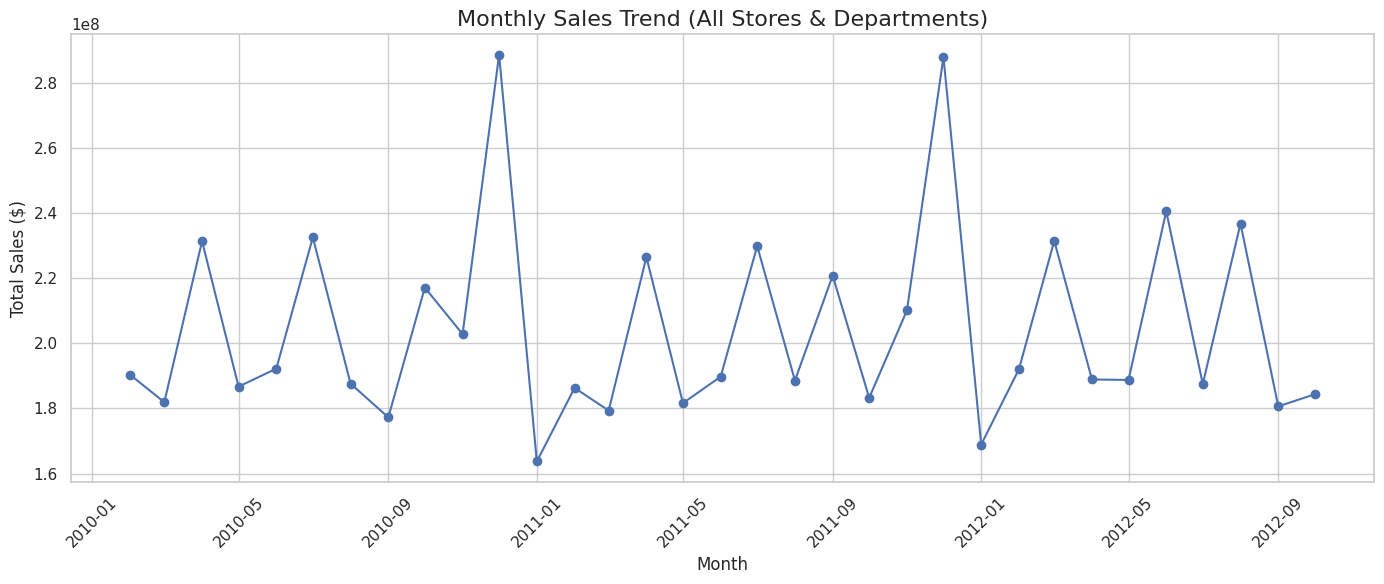

In [15]:
# Step 4: Plot monthly sales to observe trend & seasonality
plt.figure(figsize=(14, 6))
plt.plot(monthly_sales['YearMonth'], monthly_sales['Weekly_Sales'], marker='o', linestyle='-')
plt.title('Monthly Sales Trend (All Stores & Departments)', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Sales ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

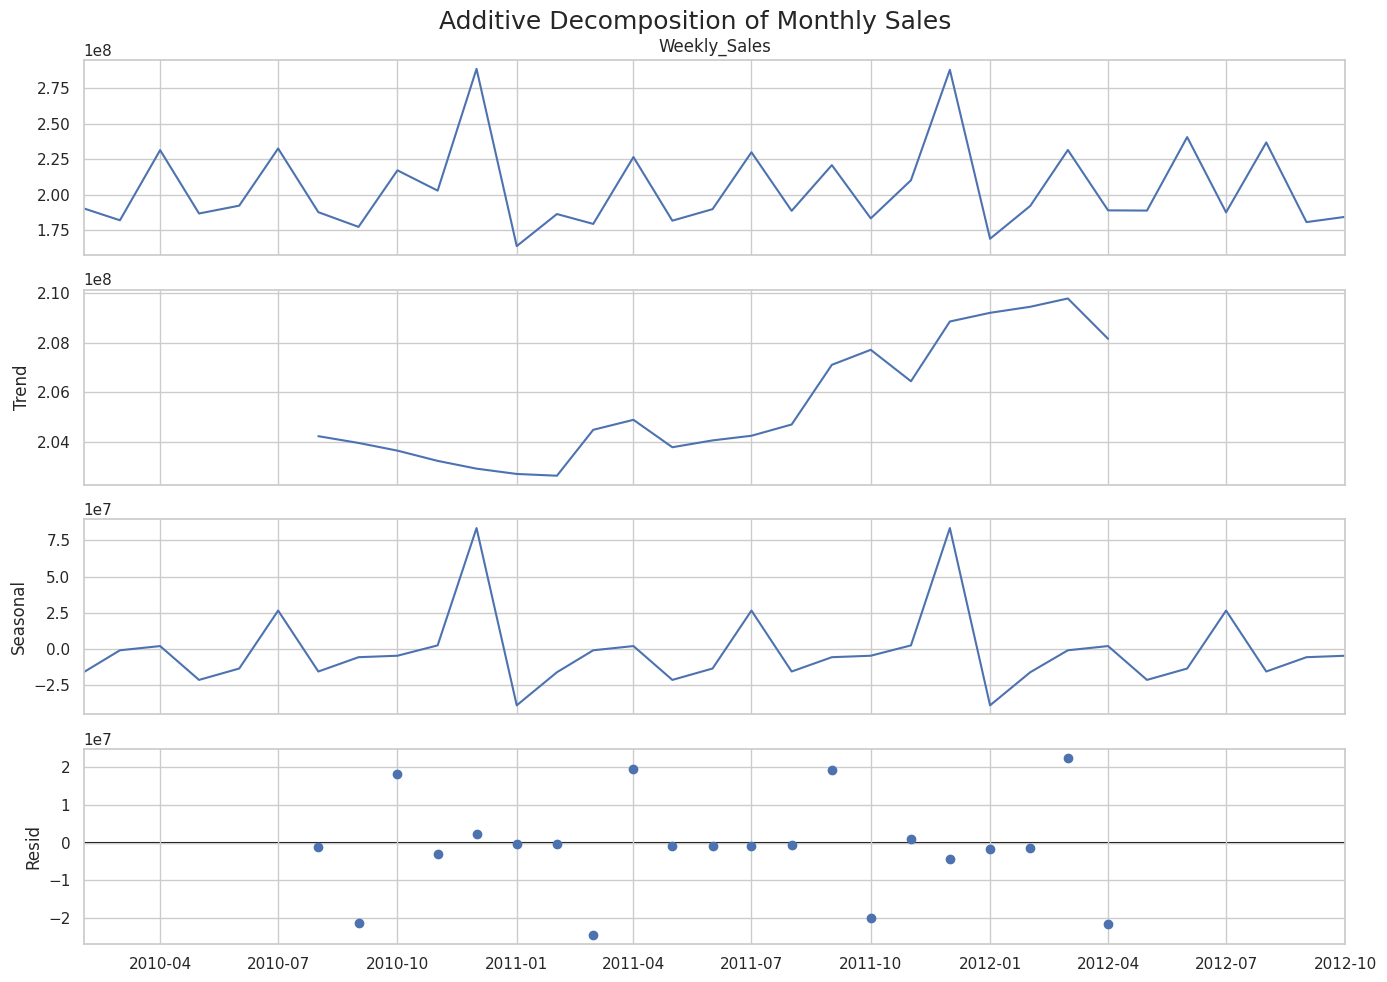

In [16]:
# Step 5: Decompose Time Series (Trend + Seasonality + Residual)

# Set date column as index
monthly_sales.set_index('YearMonth', inplace=True)

# Decompose the time series using additive model
decomposition = seasonal_decompose(monthly_sales['Weekly_Sales'], model='additive', period=12)

# Plot decomposition components
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.suptitle('Additive Decomposition of Monthly Sales', fontsize=18)
plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()

# Reset index for future steps (Prophet or ARIMA)
monthly_sales.reset_index(inplace=True)


### **Phase 3: Forecasting with Facebook Prophet**

In [17]:
# Step 1: Install Prophet (only needs to be run once)
!pip install prophet --quiet

In [19]:
# Step 2: Import libraries
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# Step 3: Prepare monthly sales data for Prophet
# Rename columns for Prophet
df_prophet = monthly_sales[['YearMonth', 'Weekly_Sales']].rename(columns={
    'YearMonth': 'ds',
    'Weekly_Sales': 'y'
})


In [21]:
# Step 4: Initialize and train Prophet model
model = Prophet()
model.fit(df_prophet)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpln6rnaxl/2la03z5m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpln6rnaxl/opbmj59w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24372', 'data', 'file=/tmp/tmpln6rnaxl/2la03z5m.json', 'init=/tmp/tmpln6rnaxl/opbmj59w.json', 'output', 'file=/tmp/tmpln6rnaxl/prophet_modelk1gvda5l/prophet_model-20250704042408.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:24:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:24:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
# Step 5: Create a future dataframe (next 6 months)
# Forecast for next 6 months
future = model.make_future_dataframe(periods=6, freq='M')  # Monthly frequency
forecast = model.predict(future)


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


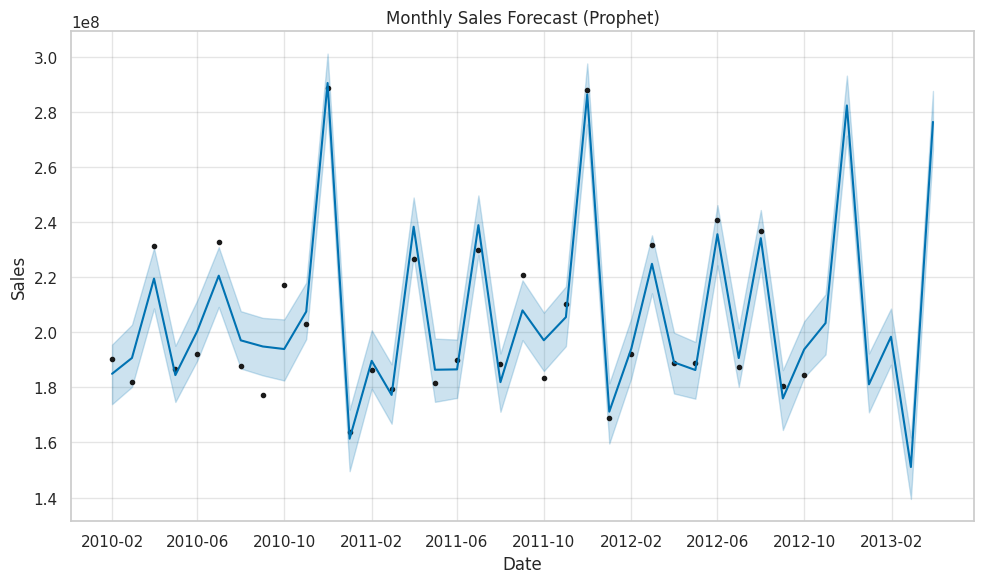

In [23]:
# Step 6: Plot the forecast
# Visualize forecast
fig = model.plot(forecast)
plt.title("Monthly Sales Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


In [24]:
# Step 7: Evaluate model accuracy on known data

# Join actual and predicted values
actual = df_prophet.set_index('ds')
predicted = forecast.set_index('ds')[['yhat']]
compare = actual.join(predicted, how='inner')

# Calculate metrics
mae = mean_absolute_error(compare['y'], compare['yhat'])
rmse = np.sqrt(mean_squared_error(compare['y'], compare['yhat']))

print("📊 MAE:", round(mae, 2))
print("📉 RMSE:", round(rmse, 2))


📊 MAE: 6672117.95
📉 RMSE: 8426418.75


### **Phase 4: Visualizing Predictions vs Actuals + Business Insights**

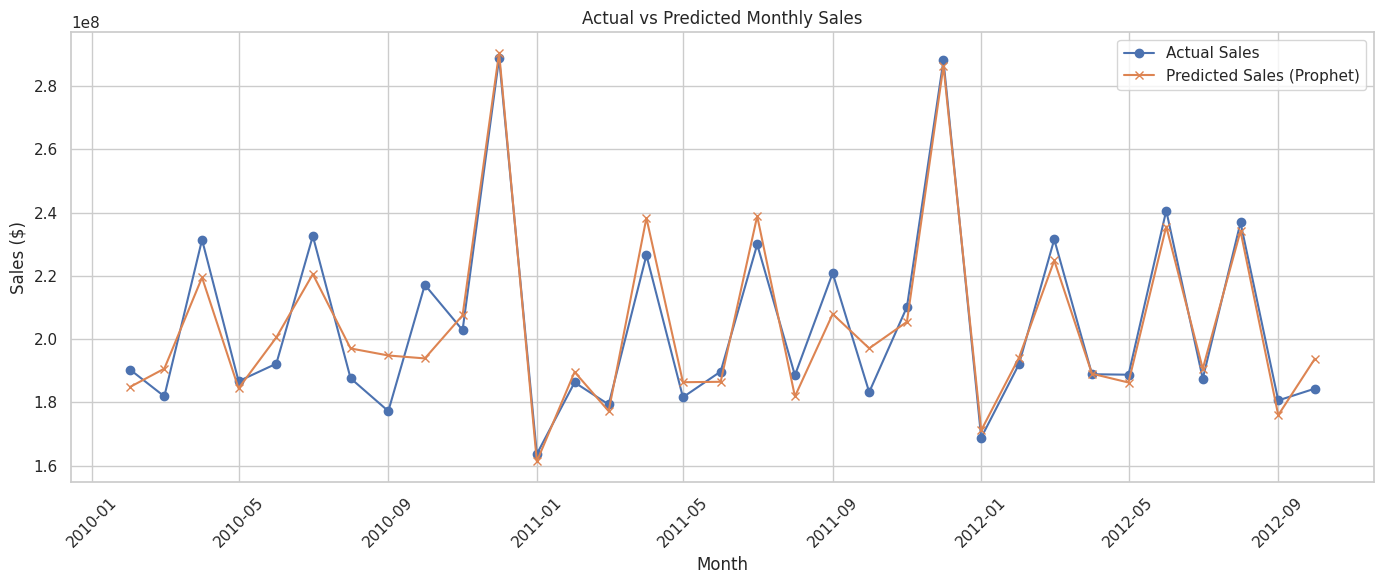

In [25]:
# Step 1: Visualize Actual vs Predicted Sales (overlapping line plot)

# Ensure alignment
compare = compare.reset_index()

# Plot actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(compare['ds'], compare['y'], label='Actual Sales', marker='o')
plt.plot(compare['ds'], compare['yhat'], label='Predicted Sales (Prophet)', marker='x')
plt.title('Actual vs Predicted Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Sales ($)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


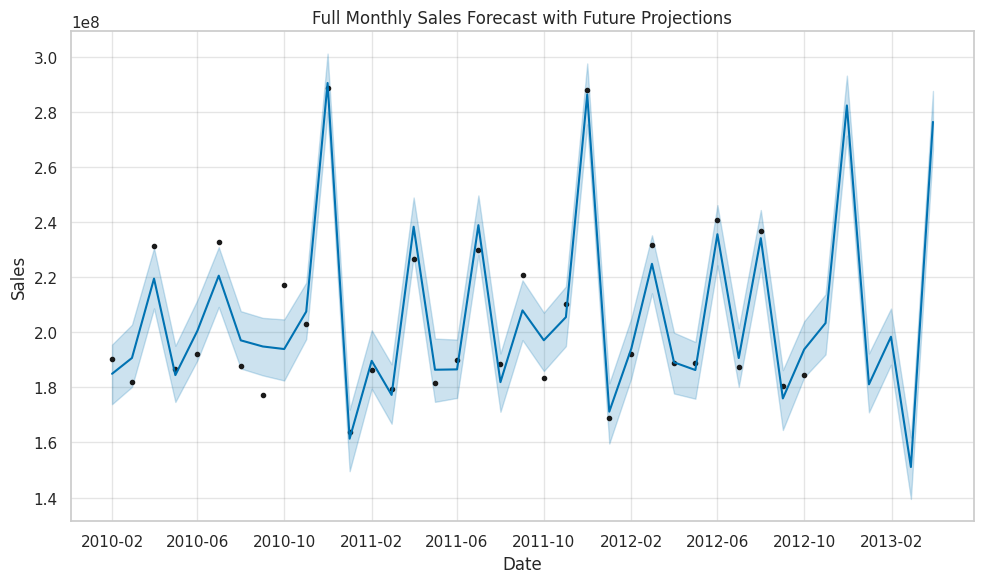

In [26]:
# Step 2: Visualize Full Forecast (including future)
# Full Forecast Plot (future + past)
fig_full = model.plot(forecast)
plt.title("Full Monthly Sales Forecast with Future Projections")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()
